## Multiple Tool Calling 

We'll define multiple tools

In [105]:
# LLM used 
from langchain_ollama import ChatOllama 

llm = ChatOllama(
    model='llama3.2',
    verbose=True,
    temperature=0.2
)

print(llm.invoke("Hey How are you?"))

content="I'm just a language model, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?" additional_kwargs={} response_metadata={'model': 'llama3.2', 'created_at': '2026-01-13T18:06:09.573762Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12289922125, 'load_duration': 211255917, 'prompt_eval_count': 30, 'prompt_eval_duration': 5800195375, 'eval_count': 47, 'eval_duration': 4470692377, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'} id='lc_run--019bb889-3093-7120-b11e-03a8fd34c07e-0' tool_calls=[] invalid_tool_calls=[] usage_metadata={'input_tokens': 30, 'output_tokens': 47, 'total_tokens': 77}


---

In [117]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
import os
import requests
from dotenv import load_dotenv
load_dotenv()

############ calculator tool ##############
@tool 
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """ 
    This function does the basic arithematic calculation 'addition' -> '+', 'subtraction' -> '-', multiplication -> '*', division -> '/'
    """
    try:
        if operation == '+':
            result = first_num + second_num 
        elif operation == '-':
            result = first_num - second_num 
        elif operation == '*':
            result = first_num * second_num 
        elif operation == '/':
            if second_num == 0:
                return {'error' : 'Cannot be divisible by zero (0)'}
            else:
                result = round(first_num/second_num, 2)

        return {'first_num' : first_num, 'second_num' : second_num, 'operation' : operation, 'result' : result}
    
    except Exception as e:
        return {'Error' : {e}}


######## Web Search ####################
@tool 
def search_on_web(topic: str) -> dict:
    "Search for information for a given topic on web."
    search = DuckDuckGoSearchRun()
    result = search.invoke(search)
    return {'topic': topic, 'result' : result}

######## Get Stock Price ###############
@tool 
def get_stock_price(symbol: str) -> dict:
    """ 
    Fetch latest stock prices for a given symbol (e.g 'AAPL', 'TSLA')
    using Alpha Vantage with API key in URL
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey={os.getenv('STOCK_API')}"
    r = requests.get(url)
    return r.json()
    

In [118]:
# configuring LLM with tools

tools = [calculator, search_on_web, get_stock_price]
llm_with_tools = llm.bind_tools(tools)

In [119]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated 
from langgraph.checkpoint.memory import InMemorySaver 
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.graph.message import add_messages # Reducer function 

# defining state 
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [120]:
# defining LLM node to chat 
def chat_llm(state: ChatState) -> ChatState:
    template = """ 
                You are a helpful chatbot that carefully thinks what to do with user query and make a relevant tool call for specific purpose and if no further tool call required it returns the final response. 

                Previous messages and current state : {messages}
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['messages']
    )

    chain = prompt | llm_with_tools 

    response = chain.invoke({'messages' : state['messages']})
    {
        'messages' : [response]
    }

# tools node 
tool_node = ToolNode(tools)

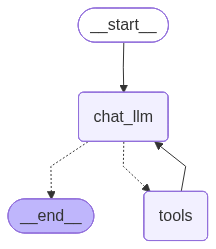

In [121]:
# make a graph 
graph = StateGraph(ChatState)

# define nodes 
graph.add_node("chat_llm", chat_llm)
graph.add_node("tools", tool_node)

# define edges 
graph.add_edge(START, "chat_llm")
graph.add_conditional_edges("chat_llm", tools_condition)
graph.add_edge("tools", "chat_llm")

# compile the graph 
checkpointer = InMemorySaver()
chatbot = graph.compile(checkpointer=checkpointer)

# display the graph 
from IPython.display import Image 
Image(chatbot.get_graph().draw_mermaid_png())


In [122]:
input_state = {'messages' : [HumanMessage(content="What is 2+2?")]}

config = {'configurable' : {'thread_id' : "3"}}

output_state = chatbot.invoke(
    input_state, 
    config=config
)

In [123]:
from pprint import pprint 
pprint(output_state)

{'messages': [HumanMessage(content='What is 2+2?', additional_kwargs={}, response_metadata={}, id='e3ec3db2-d54c-4313-a2d7-1cd3a16c3a43')]}
